In [15]:
library(ggplot2)
library(Hmisc)
source("../utilis/utilis.R")
library(glue)
library(dplyr)

In [16]:
threshold = 1
cutoff_column = 'padj'
data_df_path =  '../../../output/PS_species_v2_hMinImp_TICnorm_groupFil0.3_HILICpos_1wayANOVA/one_wayANOVA_PS_species_v2_hMinImp_TICnorm_groupFil0.3_HILICpos_fullreport.csv'
meta_df_path =  '../../../input/sequence_file/clean_deduplicated_meta_df.csv'

# Prepare the data

## Read and transform the data table and metadata table

In [17]:
df = read.csv(data_df_path, row.names = 1, sep = ',')
meta_df = read.csv(meta_df_path, row.names = 1)

----

In [18]:
grepl("^PS",PS_df[['short_name']])

[1] TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE

In [19]:
PS_df = df %>% filter(!is.na(neutral_mass))
PS_df = PS_df[grepl("^PS",PS_df[['short_name']]),]

In [20]:
head(PS_df)

,formula,neutral_mass,short_name,ion_relation,interium_id,id_number,mz,rtime,rtime_left_base,rtime_right_base,⋯,Naive_3,R5neg_1,R5neg_2,R5neg_3,R5pos_1,R5pos_2,R5pos_3,nist,q3June2014_1,q3June2014_2
,<chr>,<dbl>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
F16887,C43H74NO10P,795.5050,PS 37:5,,18418,F16887,814.5237,38.30,37.25,40.93,⋯,21.22538,19.57986,20.57986,19.57986,21.25309,21.85145,21.46881,21.44177,NA,NA
F17414,C46H78NO10P,835.5363,PS 40:6,"M0,M+H+",kp1134_835.5335,F17414,836.5404,31.21,28.32,34.10,⋯,22.37244,24.13285,24.24680,24.09082,21.21226,22.78435,22.03645,NA,NA,NA
F17672,C48H76NO10P,857.5207,PS 42:9,"M0,M+H+",kp1157_857.517,F17672,858.5225,36.20,33.31,39.35,⋯,16.15498,19.88481,20.25283,20.31554,16.15498,16.15498,16.15498,NA,NA,NA
F17876,C48H76NO10P,857.5207,PS 42:9,,18848,F17876,880.5136,38.57,36.99,40.93,⋯,20.42411,18.04788,20.15459,17.04788,17.04788,21.59848,21.23466,NA,NA,NA
F17923,C40H78NO10P,763.5363,PS 34:0,"M0,M+H+",kp1173_763.535,F17923,764.5423,24.90,23.85,28.06,⋯,22.09880,22.53209,22.62157,22.16532,21.49114,22.83666,21.92759,NA,NA,NA
F18169,C40H68NO10P,753.4581,PS 34:5,,18974,F18169,776.4484,39.09,37.52,41.46,⋯,18.55079,17.55079,17.55079,17.55079,20.28285,17.55079,18.78788,21.36539,19.19877,19.569


In [21]:
grepl('Naive\\_[0-9]|R5pos\\_[0-9]|R5neg\\_[0-9]',colnames(PS_df))

[1] FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE
[13] FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE
[25] FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE
[37] FALSE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE FALSE FALSE
[49] FALSE

In [22]:
data_df = PS_df[grepl('Naive\\_[0-9]|R5pos\\_[0-9]|R5neg\\_[0-9]',colnames(PS_df))]

In [23]:
head(data_df)

,Naive_1,Naive_2,Naive_3,R5neg_1,R5neg_2,R5neg_3,R5pos_1,R5pos_2,R5pos_3
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
F16887,21.02884,21.17845,21.22538,19.57986,20.57986,19.57986,21.25309,21.85145,21.46881
F17414,22.89911,22.48117,22.37244,24.13285,24.24680,24.09082,21.21226,22.78435,22.03645
F17672,17.15498,16.15498,16.15498,19.88481,20.25283,20.31554,16.15498,16.15498,16.15498
F17876,21.05213,20.96355,20.42411,18.04788,20.15459,17.04788,17.04788,21.59848,21.23466
F17923,21.99890,22.01227,22.09880,22.53209,22.62157,22.16532,21.49114,22.83666,21.92759
F18169,20.34357,19.19795,18.55079,17.55079,17.55079,17.55079,20.28285,17.55079,18.78788


----

In [24]:
head(meta_df)

,class,biological_samples,cell_number
,<chr>,<chr>,<int>
Naive_1,Naive,Yes,300
Naive_2,Naive,Yes,300
Naive_3,Naive,Yes,300
R5neg_1,R5neg,Yes,655
R5neg_2,R5neg,Yes,687
R5neg_3,R5neg,Yes,865


----

In [25]:
# lookUpAnnot <- function(annot_df,
#                         FeatureID,
#                         look4column = '') {
#     output = annot_df[annot_df[,'id_number'] == FeatureID,look4column]
#     return(output)
# }

# lookUpAnnot(annot_df,'F8342','Species.Shorthand')

## Transform and merge data

In [26]:
source('../utilis/utilis.R')
transform_merge_data4violin <- function(df = df,
                                 meta_df = meta_df,
                                 class_column = 'class',
                                 cutoff_column = 'padj', 
                                 threshold = threshold) {
    
    df_filt <- df[df[,cutoff_column] < threshold,
              colnames(df)[grepl('Naive\\_[0-9]|R5pos\\_[0-9]|R5neg\\_[0-9]',colnames(df))]] # 
    df_filt.T <- t(df_filt)
    # print(head(df_filt.T))
    merged_df = merge_by_rowName(meta_df,df_filt.T, all.y = TRUE)
    merged_df[,class_column] = factor(
        merged_df[,class_column],
        level = c('Naive',
                  'R5pos',
                  'R5neg')
    )
    return(merged_df)
}

In [27]:
merged_df <- transform_merge_data4violin(df = PS_df,
                                         meta_df = meta_df,
                                         class_column = 'class',
                                         cutoff_column = 'padj', 
                                         threshold = threshold)

In [28]:
colnames(merged_df)

[1] "class"              "biological_samples" "cell_number"       
 [4] "F16887"             "F17414"             "F17672"            
 [7] "F17876"             "F17923"             "F18169"            
[10] "F18473"             "F18893"

# Output directory

In [29]:
output_dir = "../../../output/PS_species_v2_hMinImp_TICnorm_groupFil0.3_HILICpos_1wayANOVA/strictPS_sum_boxplot/"
dir.create(output_dir)

In [30]:
rowsums = rowSums(merged_df[,4:ncol(merged_df)])

In [31]:
PSsum_df = merged_df[,1:3]
PSsum_df$PS_sum = rowsums

In [32]:
PSsum_df

,class,biological_samples,cell_number,PS_sum
,<fct>,<chr>,<int>,<dbl>
Naive_1,Naive,Yes,300,164.4014
Naive_2,Naive,Yes,300,160.2040
Naive_3,Naive,Yes,300,159.7077
R5neg_1,R5neg,Yes,655,163.3516
R5neg_2,R5neg,Yes,687,166.7398
R5neg_3,R5neg,Yes,865,162.1630
R5pos_1,R5pos,Yes,142,150.9490
R5pos_2,R5pos,Yes,200,158.2835
R5pos_3,R5pos,Yes,150,155.1172


# Wrapper Function: plot a single box plot

In [33]:
box_plot <- function(long_df = merged_df,
                        x = 'class',
                        y = var,
                        xlab = xlab,
                        ylab = ylab,
                        fill_color = 'class',
                        fig_width = 8,
                        fig_height = 8,
                        text_size = 20,
                        legend_size = 20,
                        axis_title_size = 20,
                        output_dir = "",
                        pdf_prefix = 'test',
                        show_plot = TRUE) {
    
    options(repr.plot.width = fig_width, repr.plot.height = fig_height)

    p <- ggplot(long_df, aes_string(x = x, y = y, fill = fill_color)) + 
        geom_boxplot(outlier.shape = NA) +
        xlab(xlab) + ylab(ylab) + 
        geom_jitter(alpha = 1) +
        scale_fill_manual(values = c("#888888","#0000ff","#ff0000")) +  #

        # set transparency
        # https://ggplot2.tidyverse.org/reference/theme.html
        theme(
          panel.grid.major = element_line(colour = "grey50",linetype = "dashed", size = 0.2),
          panel.border = element_rect(fill = NA),
          #panel.grid.minor = element_blank(),
          panel.background = element_rect(fill = "transparent",colour = NA),
          plot.background = element_rect(fill = "transparent",colour = NA),
          axis.text = element_text(size = text_size, colour="black"),
          axis.text.x = element_text(angle = 45, vjust = 0.5, hjust=0.5, colour="black"),
          legend.text= element_text(size = legend_size),
          legend.title = element_text(size = legend_size),
          axis.title = element_text(size = axis_title_size)
        )
    if (show_plot == TRUE) {
        print(p) # display the plot
    } else {return(p)}

    if (length(output_dir)!=0) {
            ggsave(file.path(output_dir, paste0("ggplot_boxplot_",pdf_prefix,".pdf")), width = fig_width, height = fig_height)
        }
}

Warning message:
“`aes_string()` was deprecated in ggplot2 3.0.0.
ℹ Please use tidy evaluation ideoms with `aes()`”
Warning message:
“The `size` argument of `element_line()` is deprecated as of ggplot2 3.4.0.
ℹ Please use the `linewidth` argument instead.”


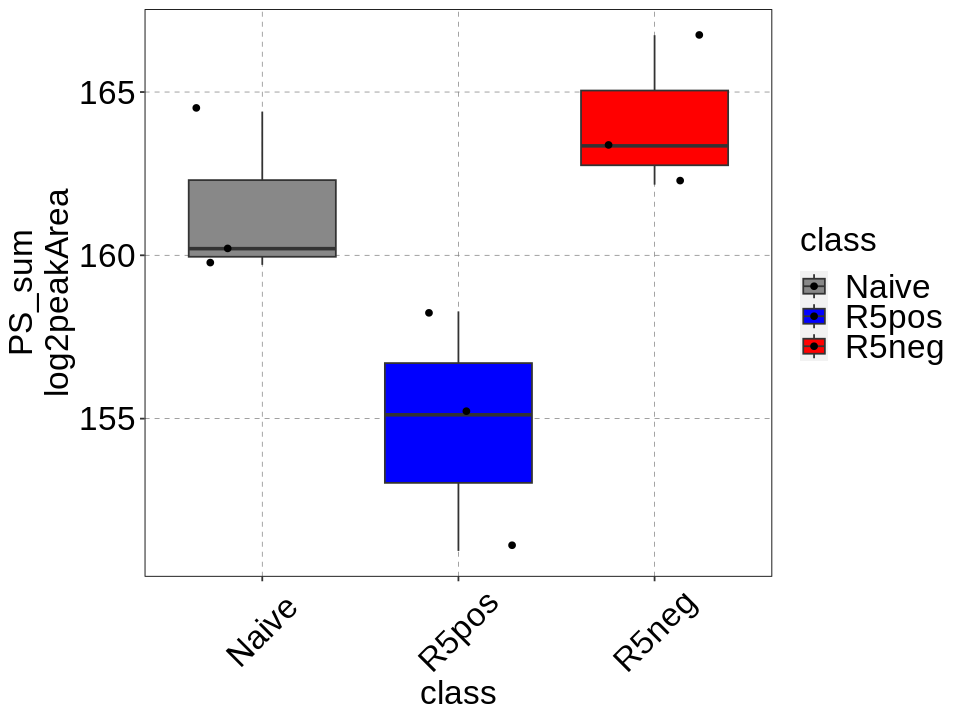

In [34]:
var = 'PS_sum'
box_plot(long_df = PSsum_df,
            x = 'class',
            y = var,
            xlab = 'class',
            ylab = glue('{var}\nlog2peakArea'),
            fill_color = 'class',
            fig_width = 8,
            fig_height = 6,
            text_size = 20,
            legend_size = 20,
            axis_title_size = 20,
            output_dir = output_dir,
            pdf_prefix = 'strict_PS_sum_HILICpos')